1. [Шаг 1. Загрузка данных и подготовка их к анализу](#start)
    * [Просмотр данных](#Viewing_data)
2. [Шаг 2. Подготовка данных](#Preparation)
    * [Изменение типа данных](#a)
    * [Проверка корректности данных](#b)
    * [Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя](#c)
    * [Количество отправленных сообщений по месяцам для каждого пользователя](#d)
    * [Объем израсходованного интернет-трафика по месяцам для каждого пользователя](#e)
    * [Помесячная выручка с каждого пользователя ](#f)
3. [Шаг 3. Анализ данных](#Analysis)  
    * [Сколько минут разговора требуется пользователям каждого тарифа в месяц?](#aa)
    * [Cколько сообщений требуется пользователям каждого тарифа в месяц?](#bb)
    * [Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?](#cc)
4. [Шаг 4. Проверка гипотез](#Hypothesis)  
    * [Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;?](#aaa)
    * [Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?](#bbb)
5. [Шаг 5. Общий вывод](#conclusion)  

## Шаг 1. Загрузка данных и подготовка их к анализу
<a id="start"></a> 

In [1]:
import pandas as pd #импортирование библиотек
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import copy
import math
import numpy as np

### Просмотр данных
<a id="Viewing_data"></a>

In [2]:
calls, internet, messages, tariffs, users = ( #чтение документов
    pd.read_csv('...'),
    pd.read_csv('...'),
    pd.read_csv('...'),
    pd.read_csv('...'),
    pd.read_csv('...'),
) 

In [3]:
calls.info() #просмотр информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


`id` — уникальный номер звонка

`call_date` — дата звонка

`duration` — длительность звонка в минутах

`user_id` — идентификатор пользователя, сделавшего звонок

In [4]:
internet.info() #просмотр информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


`id` — уникальный номер сессии

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)

`session_date` — дата интернет-сессии

`user_id` — идентификатор пользователя

In [5]:
messages.info() #просмотр информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


`id` — уникальный номер сообщения

`message_date` — дата сообщения

`user_id` — идентификатор пользователя, отправившего сообщение

In [6]:
tariffs.info() #просмотр информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
users.info() #просмотр информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


`user_id` — уникальный идентификатор пользователя

`first_name` — имя пользователя

`last_name` — фамилия пользователя

`age` — возраст пользователя (годы)

`reg_date` — дата подключения тарифа (день, месяц, год)

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

`city` — город проживания пользователя

`tariff` — название тарифного плана

**Вывод:**

Отсутствие данных были обнаруженны только в датасете `users`, в колонке `churn_date`. Данные пропуски обоснованны, так как не все пользователи прекратили пользоватся тарифом. Так же было выявленно, что надо изменить тип данных дат, в большинстве датасетах.

## Шаг 2. Подготовка данных
<a id="Preparation"></a>

###  Изменение типа данных
<a id="a"></a>

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date']) #изменение типа данных
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date']) 

In [9]:
internet = internet.drop('Unnamed: 0', axis=1) #удаление ненужного столбца

In [10]:
calls['duration'] = calls['duration'].apply(np.ceil) #округление столбца в большую сторону

In [11]:
calls.info() #просмотр измененной информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [12]:
internet.info() #просмотр измененной информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [13]:
messages.info() #просмотр измененной информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [14]:
users.info() #просмотр измененной информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


**Вывод:**

Были изменен тип данных на дату в таблицах: `calls`, `internet`, `messages` и `users`. Так же в таблице `internet`, был удален не нужный столбец. И в таблице `calls`, столбец **duration** был округлен до целого числа в большую сторону.

### Проверка корректности данных
<a id="b"></a>

In [15]:
print('Минимальное значение id:', calls['id'].min()) #просмотр корректности данных датасета calls
print('Максимальное значение id:', calls['id'].max())
print('Минимальное значение call_date:', calls['call_date'].min())
print('Максимальное значение call_date:',calls['call_date'].max())
print('Минимальное значение duration:', calls['duration'].min())
print('Максимальное значение duration:',calls['duration'].max())
print('Минимальное значение user_id:', calls['user_id'].min()) 
print('Максимальное значение user_id:', calls['user_id'].max()) 
print('Дубликатов в датафрейме calls:', calls.duplicated().sum())

Минимальное значение id: 1000_0
Максимальное значение id: 1499_99
Минимальное значение call_date: 2018-01-01 00:00:00
Максимальное значение call_date: 2018-12-31 00:00:00
Минимальное значение duration: 0.0
Максимальное значение duration: 38.0
Минимальное значение user_id: 1000
Максимальное значение user_id: 1499
Дубликатов в датафрейме calls: 0


In [16]:
print('Минимальное значение id:', internet['id'].min()) #просмотр корректности данных датасета internet
print('Максимальное значение id:', internet['id'].max())
print('Минимальное значение mb_used:', internet['mb_used'].min())
print('Максимальное значение mb_used:',internet['mb_used'].max())
print('Минимальное значение session_date:', internet['session_date'].min())
print('Максимальное значение session_date:',internet['session_date'].max())
print('Минимальное значение user_id:', internet['user_id'].min()) 
print('Максимальное значение user_id:', internet['user_id'].max()) 
print('Дубликатов в датафрейме internet:', internet.duplicated().sum())

Минимальное значение id: 1000_0
Максимальное значение id: 1499_99
Минимальное значение mb_used: 0.0
Максимальное значение mb_used: 1724.83
Минимальное значение session_date: 2018-01-01 00:00:00
Максимальное значение session_date: 2018-12-31 00:00:00
Минимальное значение user_id: 1000
Максимальное значение user_id: 1499
Дубликатов в датафрейме internet: 0


In [17]:
print('Минимальное значение id:', messages['id'].min()) #просмотр корректности данных датасета messages
print('Максимальное значение id:', messages['id'].max())
print('Минимальное значение message_date:', messages['message_date'].min())
print('Максимальное значение message_date:',messages['message_date'].max())
print('Минимальное значение user_id:', messages['user_id'].min()) 
print('Максимальное значение user_id:', messages['user_id'].max()) 
print('Дубликатов в датафрейме messages:', messages.duplicated().sum())

Минимальное значение id: 1000_0
Максимальное значение id: 1499_99
Минимальное значение message_date: 2018-01-02 00:00:00
Максимальное значение message_date: 2018-12-31 00:00:00
Минимальное значение user_id: 1000
Максимальное значение user_id: 1499
Дубликатов в датафрейме messages: 0


In [18]:
print('Уакльное значение tariff_name:', tariffs['tariff_name'].unique()) #просмотр корректности данных датасета tariffs
print('Унакльное значение rub_monthly_fee:', tariffs['rub_monthly_fee'].unique())
print('Унакльное значение minutes_included:', tariffs['minutes_included'].unique())
print('Унакльное значение messages_included:',tariffs['messages_included'].unique())
print('Унакльное значение mb_per_month_included :', tariffs['mb_per_month_included'].unique()) 
print('Унакльное значение rub_per_minute:', tariffs['rub_per_minute'].unique()) 
print('Унакльное значение rub_per_message:', tariffs['rub_per_message'].unique()) 
print('Унакльное значение rub_per_gb:', tariffs['rub_per_gb'].unique()) 
print('Дубликатов в датафрейме tariffs:', tariffs.duplicated().sum())

Уакльное значение tariff_name: ['smart' 'ultra']
Унакльное значение rub_monthly_fee: [ 550 1950]
Унакльное значение minutes_included: [ 500 3000]
Унакльное значение messages_included: [  50 1000]
Унакльное значение mb_per_month_included : [15360 30720]
Унакльное значение rub_per_minute: [3 1]
Унакльное значение rub_per_message: [3 1]
Унакльное значение rub_per_gb: [200 150]
Дубликатов в датафрейме tariffs: 0


In [19]:
print('Минимальное значение user_id:', users['user_id'].min()) #просмотр корректности данных датасета users
print('Максимальное значение user_id:', users['user_id'].max())
print('Минимальное значение reg_date:', users['reg_date'].min())
print('Максимальное значение reg_date:', users['reg_date'].max())
print('Минимальное значение churn_date:', users['churn_date'].min()) 
print('Максимальное значение churn_date:', users['churn_date'].max()) 
print('Уакльное значение tariff:', users['tariff'].unique())
print('Дубликатов в датафрейме users:', users.duplicated().sum())

Минимальное значение user_id: 1000
Максимальное значение user_id: 1499
Минимальное значение reg_date: 2018-01-01 00:00:00
Максимальное значение reg_date: 2018-12-31 00:00:00
Минимальное значение churn_date: 2018-08-17 00:00:00
Максимальное значение churn_date: 2018-12-30 00:00:00
Уакльное значение tariff: ['ultra' 'smart']
Дубликатов в датафрейме users: 0


In [20]:
print('Уакльное значение first_name:', users['first_name'].sort_values().unique()) #просмотр уникальных значений first_name

Уакльное значение first_name: ['Авксентий' 'Агата' 'Агафья' 'Агнесса' 'Адам' 'Аким' 'Аксён' 'Алан'
 'Алевтина' 'Александр' 'Александра' 'Алексей' 'Алина' 'Алиса' 'Алла'
 'Альберта' 'Альбин' 'Альфред' 'Алёна' 'Анатолий' 'Анвар' 'Ангелина'
 'Андрей' 'Анжелика' 'Анита' 'Антонина' 'Анфиса' 'Арина' 'Арнольд' 'Арсен'
 'Арсений' 'Артемий' 'Артём' 'Аурелия' 'Афанасий' 'Ахмет' 'Аюна' 'Белла'
 'Берта' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия' 'Варвара'
 'Варлам' 'Василиса' 'Вениамин' 'Вера' 'Вероника' 'Веселина' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Владимир' 'Владислав' 'Владислава'
 'Всеволод' 'Габриель' 'Габриэль' 'Гайдар' 'Галина' 'Гарри' 'Гектор'
 'Гелена' 'Геннадий' 'Геодар' 'Георгий' 'Георгина' 'Геральд' 'Герасим'
 'Глеб' 'Гордей' 'Григорий' 'Дайна' 'Дана' 'Даниил' 'Даниэла' 'Дебора'
 'Демьян' 'Денис' 'Джемма' 'Джозефина' 'Джулия' 'Динара' 'Доминика' 'Ева'
 'Евгений' 'Евгения' 'Евдокия' 'Евфросинья' 'Егор' 'Екатерина' 'Елена'
 'Еремей' 'Ермолай' 'Ефим' 'Зинаида' 'Иван' 'Игнатий

In [21]:
print('Уакльное значение last_name:', users['last_name'].sort_values().unique()) #просмотр уникальных значений last_name

Уакльное значение last_name: ['Ёлчина' 'Ёркин' 'Ёркина' 'Ёрохов' 'Ёрохова' 'Абаимов' 'Абакумов'
 'Абакшина' 'Абалакова' 'Абалдуева' 'Абалкин' 'Абашкин' 'Абашкина'
 'Абдулина' 'Абоимов' 'Абрамович' 'Абрамцев' 'Абрамычева' 'Абрашина'
 'Абрикосова' 'Авдеев' 'Авдеенко' 'Авдонюшкин' 'Авдушева' 'Авдышев'
 'Авдюков' 'Авраамова' 'Авраменко' 'Авринский' 'Аврорин' 'Авроров'
 'Авросимова' 'Авросинова' 'Авсейкина' 'Авчинникова' 'Агаев' 'Агаева'
 'Агапеева' 'Агеева' 'Адаменко' 'Адамов' 'Азаров' 'Азерников' 'Азимова'
 'Акимов' 'Акимчин' 'Акимычева' 'Акиндинов' 'Акинин' 'Акинфьев' 'Аксёнов'
 'Акуленко' 'Александрова' 'Александрович' 'Александрюк' 'Алексеева'
 'Алексеенко' 'Алексеичев' 'Аленникова' 'Алесин' 'Алехина' 'Алешин'
 'Алешина' 'Алешкова' 'Алиев' 'Алфеева' 'Алфимов' 'Алфимова' 'Алымова'
 'Алютин' 'Алюшина' 'Алёшко' 'Алёшкова' 'Амелин' 'Амелишко' 'Амельченко'
 'Ананьева' 'Андреенко' 'Андрейкин' 'Андрейчук' 'Андрианов' 'Андропов'
 'Андропова' 'Андрющенко' 'Аникина' 'Аничкина' 'Анищенко' 'Антипо

In [22]:
print('Уакльное значение age:', users['age'].sort_values().unique()) #просмотр уникальных значений age

Уакльное значение age: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]


In [23]:
print('Уакльное значение city:', users['city'].sort_values().unique()) #просмотр уникальных значений city

Уакльное значение city: ['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ростов-на-Дону' 'Рязань' 'Самара' 'Санкт-Петербург' 'Саранск' 'Саратов'
 'Севастополь' 'Смоленск' 'Сочи' 'Ставрополь' 'Стерлитамак' 'Сургут'
 'Тамбов' 'Тверь' 'Тольятти' 'Томск' 'Тула' 'Тюмень' 'Улан-Удэ'
 'Ульяновск' 'Уфа' 'Хабаровск' 'Химки' 'Чебоксары' 'Челябинск' 'Череповец'
 'Чита' 'Якутск' 'Ярославль']


**Вывод:**

В датасетах не было замеченно выбивающихся и подозрительных данных.

### Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя 
<a id="c"></a>

In [24]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month #выделение месяца из дат

In [25]:
calls.head(10) #просмотр результата

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


In [26]:
calls_month_user = calls.groupby(['user_id','month']).agg(count_duration = ('duration','count'),sum_duration = ('duration','sum')) 
 #формирование таблицы

In [27]:
calls_month_user = calls_month_user.reset_index(level=['user_id', 'month']) #изменение индекса

In [28]:
calls_month_user.head(22) #просмотр результата

,user_id,month,count_duration,sum_duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


**Вывод:**

Прослеживается неравномерное использование звонков.

### Количество отправленных сообщений по месяцам для каждого пользователя
<a id="d"></a>

In [29]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month  #выделение месяца из дат

In [30]:
messages #просмотр результата

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [31]:
messages_month_user = messages.groupby(['user_id','month'])[['id']].count() #формирование таблицы

In [32]:
messages_month_user = messages_month_user.reset_index(level=['user_id', 'month'])  #изменение индекса

In [33]:
messages_month_user = messages_month_user.rename (columns= {'id': 'messages'}) #изменение названия столбцов

In [34]:
messages_month_user.head(22) #просмотр результата

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


**Вывод:**

Прослеживается тенденция увеличения отправленных сообщений к концу года.

### Объем израсходованного интернет-трафика по месяцам для каждого пользователя
<a id="e"></a>

In [35]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month  #выделение месяца из дат

In [36]:
internet #просмотр результата

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [37]:
internet_month_user = internet.groupby(['user_id','month'])[['mb_used']].sum() #формирование таблицы

In [38]:
internet_month_user = internet_month_user.reset_index(level=['user_id', 'month'])  #изменение индекса

In [39]:
internet_month_user.head(22) #просмотр результата

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


In [40]:
internet_month_user.loc[internet_month_user['mb_used']>=41000]

,user_id,month,mb_used
159,1024,11,43107.47
383,1060,12,43931.36
799,1124,10,49745.69
1044,1165,11,42144.47
1164,1180,10,43574.62
1186,1185,8,42437.48
1187,1185,9,42181.86
1521,1240,5,43824.90
1523,1240,7,41613.55
1524,1240,8,48351.59


**Вывод:**

Прослеживается тенденция выравнивания трафика после нескольких месяцев пользования тарифом.

### Помесячная выручка с каждого пользователя 
<a id="f"></a>

In [41]:
users_tariff = users[['user_id','tariff']] #формирование таблицы

In [42]:
calls_and_messages = pd.merge(calls_month_user, messages_month_user,  how='outer', on=['user_id','month'])
all_expenses = pd.merge(calls_and_messages, internet_month_user,  how='outer', on = ['user_id','month'])
user_usage = pd.merge(all_expenses, users_tariff,  how='outer', on = ['user_id'])
use_with_conditions = pd.merge(user_usage, tariffs,  how='outer', left_on=['tariff'], right_on = ['tariff_name']).drop('tariff_name', axis=1)
#соединение таблиц

In [43]:
use_with_conditions.head(10) #просмотр результата

,user_id,month,count_duration,sum_duration,messages,mb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1
5,1000,10.0,57.0,350.0,73.0,14702.49,ultra,1000,30720,3000,1950,150,1,1
6,1000,11.0,43.0,338.0,58.0,14756.47,ultra,1000,30720,3000,1950,150,1,1
7,1000,12.0,46.0,333.0,70.0,9817.61,ultra,1000,30720,3000,1950,150,1,1
8,1003,8.0,55.0,380.0,37.0,8565.21,ultra,1000,30720,3000,1950,150,1,1
9,1003,9.0,134.0,961.0,91.0,12468.87,ultra,1000,30720,3000,1950,150,1,1


In [44]:
revenue = use_with_conditions[['user_id','month','tariff','rub_monthly_fee']].copy() #формирование таблицы

In [45]:
def minute(row):  #создание функции считающей минуты сверх тарифа
    quantity = row['sum_duration']
    tarif = row['tariff']
    minutes = row['minutes_included']
    if quantity > minutes:
        return quantity - minutes
    if quantity <= minutes:
        return 0

In [46]:
def messag(row):  #создание функции считающей сообщения сверх тарифа
    quantity = row['messages']
    tarif = row['tariff']
    mess = row['messages_included']
    if quantity > mess:
        return quantity - mess
    if quantity <= mess:
        return 0

In [47]:
def internet(row):  #создание функции считающей использованные мб сверх тарифа
    quantity = row['mb_used']
    tarif = row['tariff']
    mg = row['mb_per_month_included']
    if quantity > mg:
        return quantity - mg
    if quantity <= mg:
        return 0

In [48]:
warnings.filterwarnings('ignore') #игнорирование предупреждения

In [49]:
revenue['calls'] = use_with_conditions.apply(minute, axis=1) #запись получившихся данных в новый столбец
revenue['messages'] = use_with_conditions.apply(messag, axis=1)
revenue['used_mg'] = use_with_conditions.apply(internet, axis=1)

In [50]:
revenue.tail(10) #просмотр результата

,user_id,month,tariff,rub_monthly_fee,calls,messages,used_mg
3206,1499,9.0,smart,550,0.0,0.0,0.00
3207,1499,10.0,smart,550,0.0,0.0,2428.51
3208,1499,11.0,smart,550,112.0,9.0,2603.31
3209,1499,12.0,smart,550,0.0,16.0,0.00
3210,1489,8.0,smart,550,NaN,0.0,0.00
3211,1489,9.0,smart,550,NaN,0.0,1846.30
3212,1489,10.0,smart,550,NaN,0.0,4199.44
3213,1489,11.0,smart,550,NaN,0.0,2131.56
3214,1489,12.0,smart,550,NaN,0.0,1962.51
3215,1371,NaN,smart,550,NaN,NaN,NaN


In [51]:
revenue['revenue_from_calls'] = revenue['calls']* use_with_conditions['rub_per_minute'] 
#создание столбца с суммой переплаты за звонки

In [52]:
revenue['revenue_from_messages'] = revenue['messages']* use_with_conditions['rub_per_message']
#создание столбца с суммой переплаты за сообщения

In [53]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   tariff                 3216 non-null   object 
 3   rub_monthly_fee        3216 non-null   int64  
 4   calls                  3174 non-null   float64
 5   messages               2717 non-null   float64
 6   used_mg                3203 non-null   float64
 7   revenue_from_calls     3174 non-null   float64
 8   revenue_from_messages  2717 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 251.2+ KB


In [54]:
revenue['used_mg'] = revenue['used_mg']/1024 #перевод из мб в гб
revenue['used_mg'] = revenue['used_mg'].apply(np.ceil) #округление в большую сторону
revenue['revenue_from_internet'] = revenue['used_mg'] * use_with_conditions['rub_per_gb'] 
#создание столбца с суммой переплаты за интернет
revenue['revenue_from_internet'] = revenue['revenue_from_internet'].round(2)


In [55]:
revenue['additional_revenue'] = revenue['revenue_from_calls']+revenue['revenue_from_messages']+revenue['revenue_from_internet']+revenue['rub_monthly_fee'] 
#создание столбца с суммой общих затрат

In [56]:
revenue.head(10) #просмотр результата

,user_id,month,tariff,rub_monthly_fee,calls,messages,used_mg,revenue_from_calls,revenue_from_messages,revenue_from_internet,additional_revenue
0,1000,5.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
5,1000,10.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
6,1000,11.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
7,1000,12.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
8,1003,8.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
9,1003,9.0,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,1950.0


In [57]:
revenue_user = revenue[['user_id','month','tariff','additional_revenue']] #оптимизация таблицы

In [58]:
revenue_user.head(10) #просмотре результатов

,user_id,month,tariff,additional_revenue
0,1000,5.0,ultra,1950.0
1,1000,6.0,ultra,1950.0
2,1000,7.0,ultra,1950.0
3,1000,8.0,ultra,1950.0
4,1000,9.0,ultra,1950.0
5,1000,10.0,ultra,1950.0
6,1000,11.0,ultra,1950.0
7,1000,12.0,ultra,1950.0
8,1003,8.0,ultra,1950.0
9,1003,9.0,ultra,1950.0


In [59]:
revenue_user_ultra_1 = revenue_user.loc[revenue_user['tariff'] == 'ultra']
revenue_user_ultra_2 = revenue_user.loc[(revenue_user['additional_revenue']>1950) & (revenue_user['tariff'] == 'ultra')]
revenue_user_ultra_1 = revenue_user_ultra_1['user_id'].count()
revenue_user_ultra_2 = revenue_user_ultra_2['user_id'].count()
revenue_user_ultra = revenue_user_ultra_2*100/revenue_user_ultra_1
print(revenue_user_ultra.round(1),"%")
#подсчет превышения тарифа ultra

9.2 %


In [60]:
revenue_user_smart_1 = revenue_user.loc[revenue_user['tariff'] == 'smart']
revenue_user_smart_2 = revenue_user.loc[(revenue_user['additional_revenue']>550) & (revenue_user['tariff'] == 'smart')]
revenue_user_smart_1 = revenue_user_smart_1['user_id'].count()
revenue_user_smart_2 = revenue_user_smart_2['user_id'].count()
revenue_user_smart = revenue_user_smart_2*100/revenue_user_smart_1
print(revenue_user_smart.round(1),"%")
#подсчет превышения тарифа smart

64.6 %


**Вывод:**

Пользователи тарифа **"Смарт"**  чаще превышают лимит тарифа. 

## Шаг 3. Анализ данных
<a id="Analysis"></a> 

### Сколько минут разговора требуется пользователям каждого тарифа в месяц?
<a id="aa"></a> 

In [61]:
user_ultra_calls = use_with_conditions.loc[revenue['tariff']=='ultra'][['user_id','month','sum_duration']] #формирование таблицы

In [62]:
user_ultra_calls['sum_duration'].mean()

545.4511041009464

In [63]:
user_ultra_calls['sum_duration'].var()

94203.41839614812

In [64]:
user_ultra_calls['sum_duration'].std()

306.92575388218586

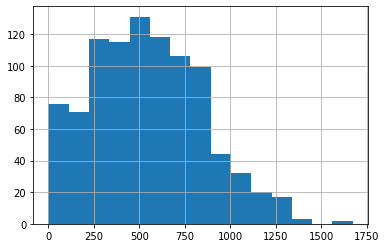

In [109]:
need_calls = user_ultra_calls['sum_duration'] #расчет оптимального времени разговора тарифа ultra по правилу трех сигм 
need_calls.hist(bins=15)
plt.show()

In [66]:
user_smart_calls = use_with_conditions.loc[revenue['tariff']=='smart'][['user_id','month','sum_duration']] #формирование таблицы

In [67]:
user_smart_calls['sum_duration'].mean()

419.0629779577148

In [68]:
user_smart_calls['sum_duration'].var()

35844.1895513438

In [69]:
user_smart_calls['sum_duration'].std()

189.3256177894154

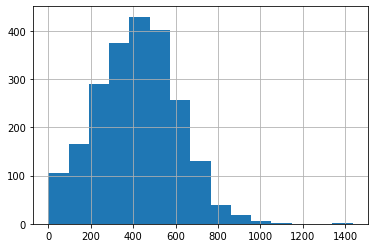

In [70]:
need_call =user_smart_calls['sum_duration']  #расчет оптимального времени разговора тарифа smart по правилу трех сигм 
need_call.hist(bins=15)
plt.show()

**Вывод:**

В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 550 минут разговора, график смещен влево, но клиенты находятся в приделах тарифа. А в тарифе **"Смарт"** в районе 420 минут, график в целом равномерный, но с выбросами в правую сторону. Много клиентов вы ходит за грань тарифа.

### Cколько сообщений требуется пользователям каждого тарифа в месяц?
<a id="bb"></a> 

In [71]:
user_ultra_messages = use_with_conditions.loc[revenue['tariff']=='ultra'][['user_id','month','messages']] #формирование таблицы

In [72]:
user_ultra_messages.head(10) #просмотр таблицы

,user_id,month,messages
0,1000,5.0,22.0
1,1000,6.0,60.0
2,1000,7.0,75.0
3,1000,8.0,81.0
4,1000,9.0,57.0
5,1000,10.0,73.0
6,1000,11.0,58.0
7,1000,12.0,70.0
8,1003,8.0,37.0
9,1003,9.0,91.0


In [73]:
user_ultra_messages['messages'].mean()

61.161006289308176

In [74]:
user_ultra_messages['messages'].var()

2109.6591828651995

In [75]:
user_ultra_messages['messages'].std()

45.93102636416042

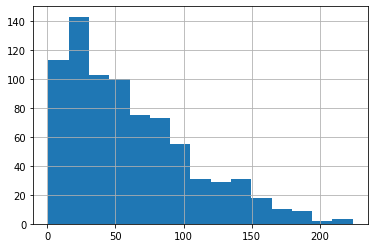

In [76]:
need_mess = user_ultra_messages['messages'] #расчет оптимального кол-ва сообщений тарифа ultra по правилу трех сигм 
need_mess.hist(bins=15)
plt.show()

In [77]:
user_smart_messages = use_with_conditions.loc[revenue['tariff']=='smart'][['user_id','month','messages']] #формирование таблицы

In [78]:
user_smart_messages.head(10) #просмотр таблицы

,user_id,month,messages
986,1001,11.0,NaN
987,1001,12.0,NaN
988,1002,6.0,4.0
989,1002,7.0,11.0
990,1002,8.0,13.0
991,1002,9.0,4.0
992,1002,10.0,10.0
993,1002,11.0,16.0
994,1002,12.0,12.0
995,1005,1.0,7.0


In [79]:
user_smart_messages['messages'].mean()

38.71644120707596

In [80]:
user_smart_messages['messages'].var()

717.5942011753547

In [81]:
user_smart_messages['messages'].std()

26.787948804926344

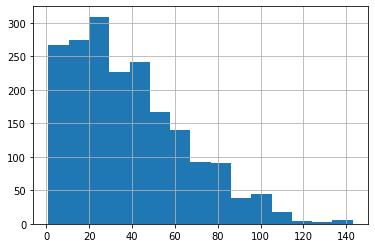

In [82]:
need_mess = user_smart_messages['messages'] #расчет оптимального кол-ва сообщений тарифа smart по правилу трех сигм  
need_mess.hist(bins=15)
plt.show()

**Вывод:**

В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 30 сообщений, график смещен влево, но все клиенты находятся в пределах тарифа. А в тарифе **"Смарт"** в районе 25 сообщений, график смещен влево, но большинство клиентов находятся до порога тарифа.

### Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
<a id="cc"></a> 

In [83]:
user_ultra_internet = use_with_conditions.loc[revenue['tariff']=='ultra'][['user_id','month','mb_used']] #формирование таблицы

In [84]:
user_ultra_internet['mb_used']  = user_ultra_internet['mb_used'] / 1025 

In [85]:
user_ultra_internet.head(10) #просмотр таблицы

,user_id,month,mb_used
0,1000,5.0,2.198527
1,1000,6.0,22.667093
2,1000,7.0,13.662088
3,1000,8.0,13.713102
4,1000,9.0,14.213571
5,1000,10.0,14.343893
6,1000,11.0,14.396556
7,1000,12.0,9.578156
8,1003,8.0,8.356302
9,1003,9.0,12.164751


In [86]:
user_ultra_internet['mb_used'].mean()

19.18876610881801

In [87]:
user_ultra_internet['mb_used'].var()

94.10041542189795

In [88]:
user_ultra_internet['mb_used'].std()

9.700536862560647

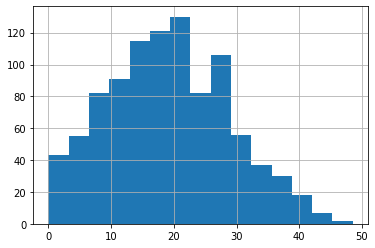

In [110]:
need_mean = user_ultra_internet['mb_used'] #расчет оптимального объёма интернет-трафика тарифа ultra по правилу трех сигм 
need_mean.hist(bins=15)
plt.show()

In [90]:
user_smart_internet = use_with_conditions.loc[revenue['tariff']=='smart'][['user_id','month','mb_used']] #формирование таблицы

In [91]:
user_smart_internet['mb_used']  = user_smart_internet['mb_used'] / 1025 

In [92]:
user_smart_internet

,user_id,month,mb_used
986,1001,11.0,17.979844
987,1001,12.0,13.694302
988,1002,6.0,10.592020
989,1002,7.0,17.151317
990,1002,8.0,19.823668
...,...,...,...
3211,1489,9.0,16.786634
3212,1489,10.0,19.082380
3213,1489,11.0,17.064937
3214,1489,12.0,16.900010


In [93]:
user_smart_internet['mb_used'].mean()

15.820157901650829

In [94]:
user_smart_internet['mb_used'].var()

32.70429666368415

In [95]:
user_smart_internet['mb_used'].std()

5.718767058001589

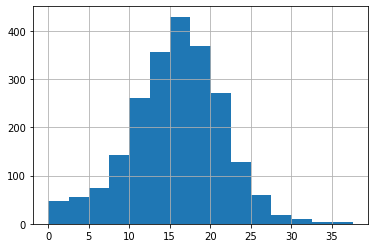

In [111]:
need_gb = user_smart_internet['mb_used'] #расчет оптимального объёма интернет-трафика тарифа smart по правилу трех сигм 
need_gb.hist(bins=15)
plt.show()

**Вывод:**

В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 20 гб, график смещен влево, что говорит что больше людей пользуется меньшим колличеством гб чем 20. А в тарифе **"Смарт"** в районе 16 гб, график равномерно распределен. 

## Шаг 4. Проверка гипотез
<a id="Hypothesis"></a> 

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
<a id="aaa"></a> 

**Нулевая гипотеза**: Средняя выручка тарифа "Ультра" и тарифа "Смарт" равны. 

**Альтернативная гипотеза**: Средняя выручка тарифа "Ультра" и тарифа "Смарт" не равны.

In [97]:
revenue_user #просмотр таблицы

,user_id,month,tariff,additional_revenue
0,1000,5.0,ultra,1950.0
1,1000,6.0,ultra,1950.0
2,1000,7.0,ultra,1950.0
3,1000,8.0,ultra,1950.0
4,1000,9.0,ultra,1950.0
...,...,...,...,...
3211,1489,9.0,smart,NaN
3212,1489,10.0,smart,NaN
3213,1489,11.0,smart,NaN
3214,1489,12.0,smart,NaN


In [98]:
revenue_ultra = revenue_user.loc[revenue['tariff']=='ultra','additional_revenue'].fillna(value=0) 
#формирование таблицы с тарифом ultra

In [99]:
revenue_smart = revenue_user.loc[revenue['tariff']=='smart','additional_revenue'].fillna(value=0) 
#формирование таблицы с тарифом smart

In [100]:
alpha = 0.05  #проверка гипотезы
results = st.ttest_ind(revenue_ultra,revenue_smart)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.052587794276283e-39
Отвергаем нулевую гипотезу


**Вывод:**

Средняя выручка пользователей тарифа "Ультра" **отличается** от средней выручки пользователей тарифа "Смарт".

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
<a id="bbb"></a> 

**Нулевая гипотеза**: Средняя выручка пользователей из москвы равна средней выручки пользователей других регионов.

**Альтернативная гипотеза**: Средняя выручка пользователей из москвы не равна средней выручки пользователей других регионов.

In [101]:
users2 = users[['user_id','city']] #формирование таблицы

In [102]:
users2 #просмотр таблицы

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк
...,...,...
495,1495,Иркутск
496,1496,Вологда
497,1497,Челябинск
498,1498,Владикавказ


In [103]:
revenue_user_region = pd.merge(revenue_user, users2,  how='left', left_on=['user_id'], right_on = ['user_id']) 
#формирование таблицы с регионами

In [104]:
revenue_user_region #просмотр получившийся таблицы

,user_id,month,tariff,additional_revenue,city
0,1000,5.0,ultra,1950.0,Краснодар
1,1000,6.0,ultra,1950.0,Краснодар
2,1000,7.0,ultra,1950.0,Краснодар
3,1000,8.0,ultra,1950.0,Краснодар
4,1000,9.0,ultra,1950.0,Краснодар
...,...,...,...,...,...
3211,1489,9.0,smart,NaN,Санкт-Петербург
3212,1489,10.0,smart,NaN,Санкт-Петербург
3213,1489,11.0,smart,NaN,Санкт-Петербург
3214,1489,12.0,smart,NaN,Санкт-Петербург


In [105]:
revenue_region_moscow = revenue_user_region.loc[revenue_user_region['city']=='Москва','additional_revenue'].fillna(value=0)
#формирование таблицы с регионом Москва

In [106]:
revenue_region_not_moscow = revenue_user_region.loc[revenue_user_region['city']!='Москва','additional_revenue'].fillna(value=0) 
#формирование таблицы с остальными регионами

In [107]:
alpha = 0.05  #проверка гипотезы
results = st.ttest_ind(revenue_region_moscow,revenue_region_not_moscow)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.9591721970211647
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Cредняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов

## Шаг 5. Общий вывод
<a id="conclusion"></a> 

При просмотре датасетов, отсутствие данных были обнаруженны только в датасете `users`, в колонке `churn_date`. Данные пропуски обоснованны, так как не все пользователи прекратили пользоватся тарифом. Так же было выявленно, что надо изменить тип данных дат, в большинстве датасетах.

Были изменен тип данных на дату в таблицах: `calls`, `internet`, `messages` и `users`. Так же в таблице `internet`, был удален не нужный столбец.  И в таблице `calls`, столбец **duration** был округлен до целого числа в большую сторону.

При проверке корректности данных в датасетах, не было замеченно выбивающихся и подозрительных данных.

При подготовке данных были сделанны следующие выводы: 
- Прослеживается неравномерное использование звонков.
- Прослеживается тенденция увеличения отправленных сообщений к концу года.
- Прослеживается тенденция выравнивания трафика после нескольких месяцев пользования тарифом.
- Пользователи тарифа **"Смарт"** чаще превышают лимит тарифа. 

При анализе данных было выявленно, что:
- В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 550 минут разговора, график смещен влево, но клиенты находятся в приделах тарифа. А в тарифе **"Смарт"** в районе 420 минут, график в целом равномерный, но с выбросами в правую сторону. Много клиентов вы ходит за грань тарифа.
- В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 30 сообщений, график смещен влево, но все клиенты находятся в пределах тарифа. А в тарифе **"Смарт"** в районе 25 сообщений, график смещен влево, но большинство клиентов находятся до порога тарифа.
- В тарифе **"Ультра"**, как показано на гистаграмме, чаще всего используют в районе 20 гб, график смещен влево, что говорит что больше людей пользуется меньшим колличеством гб чем 20. А в тарифе **"Смарт"** в районе 16 гб, график равномерно распределен. 

При проверке гепотез, выяснилось что:
- Средняя выручка пользователей тарифа "Ультра" **отличается** от средней выручки пользователей тарифа "Смарт".
- Cредняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов.

Так как в тарифе **"Смарт"** много клиентов выходят за грани тарифа, для них это не очень выгодный тариф. Более выгодным выглядит **"Ультра"**, но при рассмотрении использованных ресурсов, можно сказать, что их можно уменьшить.

**Ркомендации**